<a id="linreg_1d"></a>
# Demo: linear regression in one dimension

In [1]:
## External modules.
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import lognorm, norm

## Internal modules.
from mml.algos.gd import GD_ERM
from mml.losses.quadratic import Quadratic
from mml.models.linreg import LinearRegression
from mml.utils import makedir_safe
from setup_losses import M_Risk
from setup_results import img_dir, results_dir, my_fontsize, my_ext, export_legend

In [2]:
## Create directory to save figures.
#makedir_safe(img_dir) # uncomment if you plan to save figures.

In [3]:
## Setup.
n_train = 10000
num_trials = 100
batch_size = 8
noise_name = "normal"

rg = np.random.default_rng()

w_star = np.array([1.0, 1.0], ndmin=2).T


## Data generation.

def gen_noise(n, name):
    '''
    Returns zero-mean noise.
    '''
    
    if name == "normal":
        noise = rg.normal(loc=0.0, scale=0.8, size=(n,1))
    elif name == "lognormal":
        sigma = 0.8
        mean = 0.0
        lognormal_mean = lognorm.stats(s=sigma,
                                       scale=np.exp(mean),
                                       moments="m")
        noise = rg.lognormal(mean=mean,
                             sigma=sigma,
                             size=(n,1)) - lognormal_mean
    elif name == "neglognormal":
        sigma = 0.8
        mean = 0.0
        lognormal_mean = lognorm.stats(s=sigma,
                                       scale=np.exp(mean),
                                       moments="m")
        noise = -(rg.lognormal(mean=mean,
                               sigma=sigma,
                               size=(n,1)) - lognormal_mean)
    else:
        raise ValueError("Please provide a proper noise name.")
    
    return noise


def gen_X(n):
    x1 = rg.normal(loc=0.0, scale=1.0, size=(n,1))
    x2 = np.ones_like(x1)
    return np.hstack([x1,x2])


In [4]:
# Driver script, given a range of sigma values.

## Sigma value.
todo_sigma = [0.0, 0.1, 1.0, 10.0, 100.0, np.inf]

## Algorithm setup size.
step_size = 0.001

## Storage over exp settings.
store_over_settings = {}

for sigma in todo_sigma:
    
    print("CURRENT SIGMA:", sigma)
    
    ## Storage over trials.
    slope_over_trials = []
    intercept_over_trials = []
    
    for trial in range(num_trials):

        ## Loss setup.
        loss_base = Quadratic()
        loss_mrisk = M_Risk(loss_base=loss_base, sigma=sigma, eta=None)

        ## Model setup.
        model = LinearRegression(num_features=2, rg=rg)
        model.paras["theta"] = rg.uniform(low=0.0, high=0.05, size=(1,1))

        ## Algorithm setup.
        algo = GD_ERM(step_coef=step_size, model=model, loss=loss_mrisk)

        ## Data setup.
        X_train = gen_X(n=n_train)
        y_train = np.matmul(X_train, w_star) + gen_noise(n=len(X_train), name=noise_name)
        
        ## Do the training, one datapoint at a time.
        num_steps = n_train // batch_size
        idx_start = 0
        idx_stop = min(batch_size, n_train)
        for step in range(num_steps):
            algo.update(X=X_train[idx_start:idx_stop,:],
                        y=y_train[idx_start:idx_stop,:])
            idx_start += batch_size
            idx_stop = min(idx_start+batch_size, n_train)
        
        ## Store the final learned candidate this trial.
        slope_over_trials += [algo.paras["w"][0]]
        intercept_over_trials += [algo.paras["w"][1]]
        
    ## Turn the stored parameters into an ndarray.
    slope_over_trials = np.array(slope_over_trials)
    intercept_over_trials = np.array(intercept_over_trials)
    
    #print("Finished all trials for this sigma. Printing results:")
    #print(np.column_stack((slope_over_trials, intercept_over_trials)))
    
    ## Finally, store this setting-specific array.
    key = str(sigma)
    store_over_settings[key] = (slope_over_trials, intercept_over_trials)

CURRENT SIGMA: 0.0
CURRENT SIGMA: 0.1
CURRENT SIGMA: 1.0
CURRENT SIGMA: 10.0
CURRENT SIGMA: 100.0
CURRENT SIGMA: inf


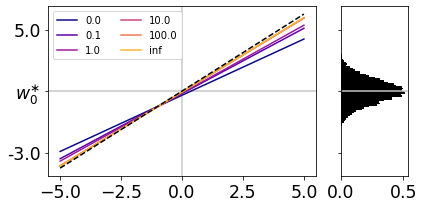

In [5]:
## Colour setup.
sigma_cmap = cm.get_cmap("plasma")
sigma_names = [key for key in store_over_settings]
sigma_colours = {}
for i, key in enumerate(sigma_names):
    sigma_colours[key] = sigma_cmap(i/len(sigma_names))

## Visualize the stored parameter values over time.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3),
                               gridspec_kw={"width_ratios": [4, 1]},
                               sharey=True)
x_values = np.linspace(-5, 5, 1000)
ax1.axhline(y=w_star[1], color="xkcd:silver")
ax1.axvline(x=0.0, color="xkcd:silver")
for key in store_over_settings:
    slopes, intercepts = store_over_settings[key]
    slope = np.mean(slopes)
    intercept = np.mean(intercepts)
    y_values = x_values*slope + intercept
    ax1.plot(x_values, y_values, color=sigma_colours[key], label=key)
ax1.plot(x_values, w_star[0]*x_values + w_star[1], color="xkcd:black", ls="--")
ax1.tick_params(labelsize=my_fontsize)
ax1.legend(loc=None, ncol=2)

ax2.axhline(y=w_star[1], color="xkcd:silver")
ax2.hist(w_star[1]+gen_noise(n=len(X_train), name=noise_name),
         bins="auto",
         color="black", hatch=None, orientation="horizontal",
         density=True)
ax2.tick_params(labelsize=my_fontsize)
#ax2.label_outer()
#ax2.set_ylim((-5,10)) # set as needed to ensure good visibility.
ticks = [-3., w_star[1].item(), 5.]
tick_labels = [-3., r"$w_{0}^{\ast}$", 5.]
ax2.set_yticks(ticks)
ax2.set_yticklabels(tick_labels)
#fig.suptitle(r"Regression lines (for varying $\sigma$) and noise densities", size=my_fontsize)
fname = os.path.join(img_dir, "linreg_1d_{}.{}".format(noise_name, my_ext))
plt.tight_layout()
#plt.savefig(fname=fname) # uncomment to save figure.
plt.show()

___